In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/students-performance-dataset/Student_performance_data _.csv')
df.head() 

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [2]:
df.shape

(2392, 15)

In [3]:
# Drop Duplicates
df = df.drop_duplicates()
df = df.drop(['GradeClass'], axis=1)

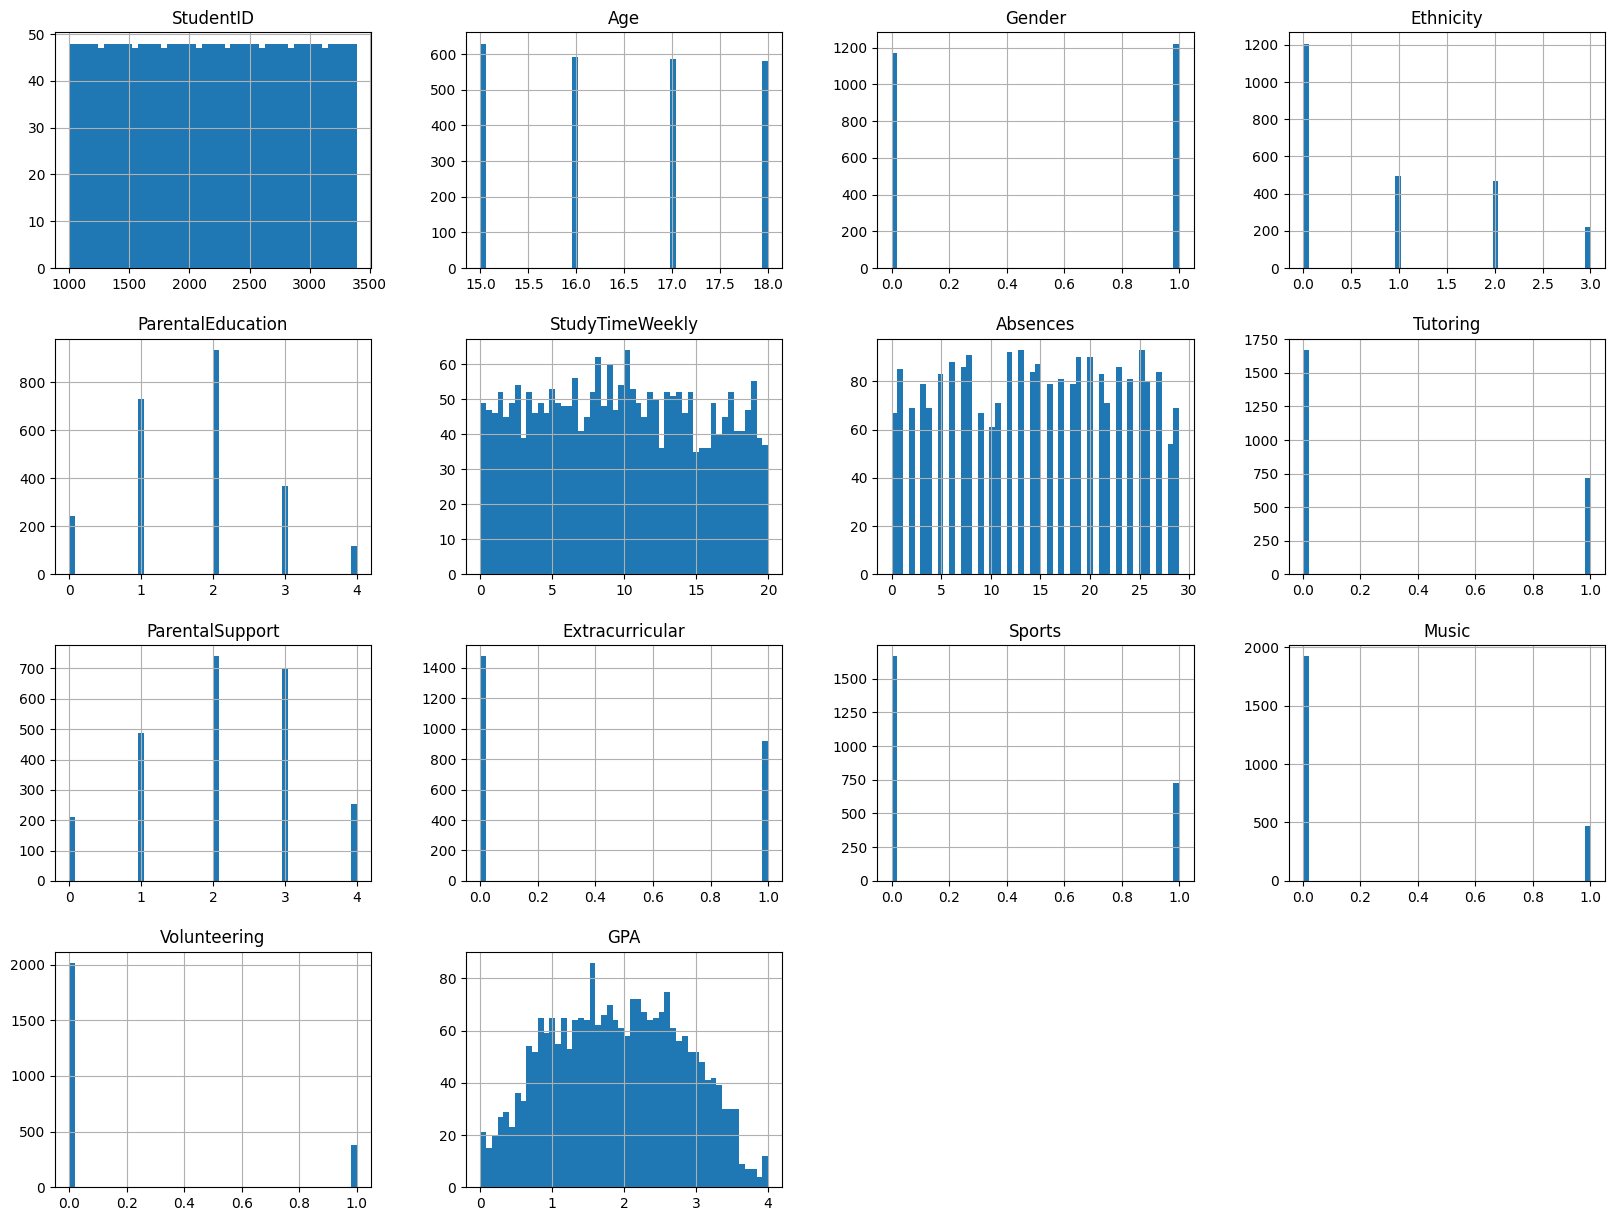

In [4]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df,explorative = True, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
print(df.select_dtypes(['float', 'int']).columns)

print(df.select_dtypes(['object', 'bool']).columns)

Index(['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation',
       'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport',
       'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA'],
      dtype='object')
Index([], dtype='object')


In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
X = df.drop(['GPA'], axis=1)
y = df['GPA']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['StudentID', 'Age', 'StudyTimeWeekly', 'Absences']
categorical_features = ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport',
                       'Extracurricular', 'Sports', 'Music', 'Volunteering']

In [9]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
}

In [11]:
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}==>")
    
    # Create pipeline with preprocessor and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    try:
        # Perform cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                  cv=5, scoring='r2')
        
        # Fit the model on full training data
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        train_pred = pipeline.predict(X_train)
        test_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        
        # Print results
        print(f"CV R2: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        print(f"Train R2: {train_r2:.3f}")
        print(f"Test R2: {test_r2:.3f}")
        print(f"Train RMSE: {train_rmse:.3f}")
        print(f"Test RMSE: {test_rmse:.3f}")
        
        # Store results
        results[name] = {
            'CV Mean R2': cv_scores.mean(),
            'CV Std R2': cv_scores.std(),
            'Train R2': train_r2,
            'Test R2': test_r2,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Pipeline': pipeline
        }
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue


Training Linear Regression==>
CV R2: 0.953 (±0.007)
Train R2: 0.954
Test R2: 0.953
Train RMSE: 0.196
Test RMSE: 0.198

Training Ridge==>
CV R2: 0.953 (±0.007)
Train R2: 0.954
Test R2: 0.953
Train RMSE: 0.196
Test RMSE: 0.198

Training Lasso==>
CV R2: -0.003 (±0.001)
Train R2: 0.000
Test R2: -0.001
Train RMSE: 0.916
Test RMSE: 0.910

Training Random Forest==>
CV R2: 0.925 (±0.009)
Train R2: 0.990
Test R2: 0.923
Train RMSE: 0.091
Test RMSE: 0.253


In [12]:
best_model = max(results.items(), key=lambda x: x[1]['Test R2'])[0]
print(f"\nBest performing model: {best_model}")


Best performing model: Linear Regression


In [13]:
import joblib 

joblib.dump(results['Linear Regression']['Pipeline'], 'student_gpa_predictor.joblib')
loaded_model = joblib.load('student_gpa_predictor.joblib')